In [39]:
import torch
import torch.nn as nn
import argparse
import pandas as pd
import wandb
import matplotlib.pyplot as plt
from tqdm import tqdm
from model import get_model
from dataloader import CorroSeg
from utils import iou_score,  RollTransform
from losses import SoftIoULoss, FocalLoss
from dataloader import CorroSeg, CorroSegDataset
import torchvision.transforms as transforms
import torch.nn.functional as F
import numpy as np 
import os
import datetime
from datetime import datetime
import easydict

In [17]:
freq_corrosion = 7/100
def train(args):

    if args.experiment_name is None:
            args.experiment_name = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
            
    if(args.wandb):
        wandb.init(
            name=args.experiment_name,
            id=args.wandb_id,
            entity=args.wandb_entity,
            project="corroseg",
        )
        
        wandb.config = {
            "architecture":args.model_name,
            "epochs":args.num_epochs,
            "learning_rate":args.learning_rate,
        }
        
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = get_model(model_name=args.model_name, backbone_name=args.backbone, backbone_pretrained=args.pretrained).to(device)
    

    # Possible transforms: transforms.RandomHorizontalFlip(), transforms.RandomVerticalFlip(), t
        
    transform_img = [None,
        transforms.RandomHorizontalFlip(1),
        transforms.RandomVerticalFlip(1),RollTransform(),
        transforms.Compose([transforms.RandomVerticalFlip(1),transforms.RandomHorizontalFlip(1)]),]
 
    
    corro_seg = CorroSeg('data', 'y_train.csv', shuffle = True,
                 batch_size = args.batch_size, valid_ratio = args.valid_ratio, transform_img=transform_img,  
                 transform_test=None, test_params={'batch_size': args.batch_size, 'shuffle': False})
    train_loader, val_loader, test_loader = corro_seg.get_loaders()
    print("Data loaded")
    # print("Number of training images: ", len(train_loader.dataset))
    # print("Number of validation images: ", len(val_loader.dataset))
    # print("Number of test images: ", len(test_loader.dataset))

    # Loss function and optimizer definition
    if args.criterion == 'bce':
        criterion = nn.BCEWithLogitsLoss()
    elif args.criterion == 'iou':
        criterion = SoftIoULoss()
    elif args.criterion == 'focal':
        criterion = FocalLoss(args.gamma,args.alpha)
    optimizer = torch.optim.Adam(model.parameters(), lr=args.learning_rate, weight_decay=args.weight_decay)


    for epoch in tqdm(range(args.num_epochs)):
        # Defreezing strategy
        if args.defreezing_strategy and (epoch % args.unfreeze_at_epoch == 0):
            layers_to_unfreeze = (epoch // args.unfreeze_at_epoch) * args.layers_to_unfreeze_each_time
            model.unfreeze_layers(layers_to_unfreeze)
        
        # Training phase
        model.train()
        train_loss = 0.0
        train_iou = 0.0
        
        for image, mask, well in tqdm(train_loader):
            if args.model_need_GRAY:
                image = torch.mean(image, dim=1, keepdim=True)
            mask = torch.mean(mask, dim=1, keepdim = True)
            optimizer.zero_grad()
            image = image.to(device)  # Move image to device
            mask = mask.to(device)  # Move mask to device
            outputs = model(image)
            # print('outputs',outputs.shape)
            # print('mask',mask.shape)

            loss = criterion(outputs, mask)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * image.size(0)
            # Apply threshold to get binary predictions
            preds = (outputs - args.threshold).round()
            train_iou += iou_score(preds, mask).item() * image.size(0)
        
        train_loss /= len(train_loader.dataset)
        train_iou /= len(train_loader.dataset)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_iou = 0.0
        
        with torch.no_grad():
            for image, mask, well in tqdm(val_loader):
                if args.model_need_GRAY:
                    image = torch.mean(image, dim=1, keepdim=True)
                mask = torch.mean(mask, dim=1, keepdim = True)
                image = image.to(device)  # Move image to device
                mask = mask.to(device)  # Move mask to device
                outputs = model(image)
                outputs = outputs.detach()  # Detach outputs from the computation graph
                loss = criterion(outputs, mask)
                val_loss += loss.item() * image.size(0)
                # Apply threshold to get binary predictions
                preds = (outputs - args.threshold).round()
                val_iou += iou_score(preds, mask).item() * image.size(0)
        
        val_loss /= len(val_loader.dataset)
        val_iou /= len(val_loader.dataset)
        
        # Logging to Weights and Biases
        if(args.wandb):
            wandb.log({'Train Loss': train_loss, 'Train IoU': train_iou,
                    'Validation Loss': val_loss, 'Validation IoU': val_iou}, step=epoch)
        
        print(f'Epoch {epoch+1}/{args.num_epochs}, Train Loss: {train_loss:.4f}, Train IoU: {train_iou:.4f}, Validation Loss: {val_loss:.4f}, Validation IoU: {val_iou:.4f}')
        
    # Testing phase
    model.eval()
    predicted_masks = []  # List to store predicted masks
    with torch.no_grad():
        for image, _, _ in test_loader:  # Ignore the masks in the test loader
            if args.model_need_GRAY:
                image = torch.mean(image, dim=1, keepdim=True)

            image = image.to(device)
            output = model(image).detach()
            preds = output > args.threshold  # Apply threshold to get binary predictions
            preds = preds.int()

            # Check the unique values and values less than -100
            unique_values = torch.unique(image)
            # if len(unique_values) < 10 or torch.any(image < -100):
            if torch.any(image < -100):
                preds = torch.zeros_like(preds).int()  # Reset preds to zeros if conditions are met

            # Ensure consistent shape for all flattened masks
            flattened_mask = preds.cpu().numpy().reshape(-1, 36*36)  # Explicitly specify the flattened shape
            predicted_masks.extend(flattened_mask)

    # Save predicted masks to a CSV file
    predicted_masks = np.vstack(predicted_masks)  # Stack the list of arrays into a single 2D array
    df = pd.DataFrame(predicted_masks)

    files = [f.replace('.npy','') for f in os.listdir('data/processed/images_test')]
    df.index = files

    prediction_path = "data/predictions/submission_" + args.experiment_name + '.csv'
    df.to_csv(prediction_path, index=True)

    print("Predicted masks saved to predicted_masks.csv")

    return model, criterion

In [18]:
args = easydict.EasyDict({'num_epochs': 1, 'criterion': 'iou', 'batch_size': 64, 'valid_ratio': 0.1, 
          'model_name': 'jacard_unet', 'backbone': 'efficientnet-v2-m', 'learning_rate': 2e-5, 
          'threshold': 0.5, 'defreezing_strategy': False, 'unfreeze_at_epoch': 0, 
          'layers_to_unfreeze_each_time': 100, 'weight_decay': 0.01, 'gamma': 3,
          'experiment_name': 'test', 'wandb': False, 'wandb_id': None, 'wandb_entity': None,
          'output_dir': 'wandb', 'model_need_GRAY':False, 'pretrained':True, 'alpha':0.25})

In [19]:
model, criterion = train(args)

Data loaded


100%|██████████| 1/1 [12:11<00:00, 731.11s/it]


Epoch 1/1, Train Loss: -0.0450, Train IoU: 0.1564, Validation Loss: -0.0434, Validation IoU: 0.1496
Predicted masks saved to predicted_masks.csv


In [20]:
corro_seg = CorroSeg('data', 'y_train.csv', shuffle = True,
                 batch_size = 1,  valid_ratio = args.valid_ratio, transform_img=None,  
                 transform_test=None, test_params={'batch_size': args.batch_size, 'shuffle': False})
train_loader, val_loader, test_loader = corro_seg.get_loaders()

In [24]:
list_loss = []
model.eval()
for image, mask, well in tqdm(train_loader):
    output = model(image)
    loss = criterion(output, mask)
    list_loss.append(loss.detach().numpy())


100%|██████████| 8397/8397 [02:04<00:00, 67.61it/s]


In [26]:
print(np.array(list_loss))

[0.08290503 0.05543886 0.06370359 ... 0.0591383  0.05820519 0.05449671]


torch.Size([1, 3, 36, 36])
tensor([[[[-1.6678e+00, -1.5015e+00, -7.5926e-01,  ..., -6.8298e-01,
           -8.1210e-01, -1.1266e+00],
          [-5.1892e+00,  3.3106e-01,  5.2323e-01,  ..., -5.3397e+00,
           -4.9592e+00, -4.9539e+00],
          [ 2.1802e+00,  2.2950e+00,  1.3393e+00,  ..., -5.2043e-01,
           -5.4929e-01, -5.7567e-01],
          ...,
          [-1.7430e-01, -3.9899e-01, -1.4634e-01,  ...,  1.8640e-01,
            8.0486e-02,  1.5157e-01],
          [-7.4163e-01, -6.2011e-01, -3.7400e-01,  ...,  6.4075e-01,
            2.3634e-03, -7.7651e-01],
          [-8.0249e-01, -8.6589e-01, -7.7545e-01,  ...,  6.1934e-01,
           -1.7519e-01, -7.7803e-01]],

         [[-1.6678e+00, -1.5015e+00, -7.5926e-01,  ..., -6.8298e-01,
           -8.1210e-01, -1.1266e+00],
          [-5.1892e+00,  3.3106e-01,  5.2323e-01,  ..., -5.3397e+00,
           -4.9592e+00, -4.9539e+00],
          [ 2.1802e+00,  2.2950e+00,  1.3393e+00,  ..., -5.2043e-01,
           -5.4929e-01, -5.7567

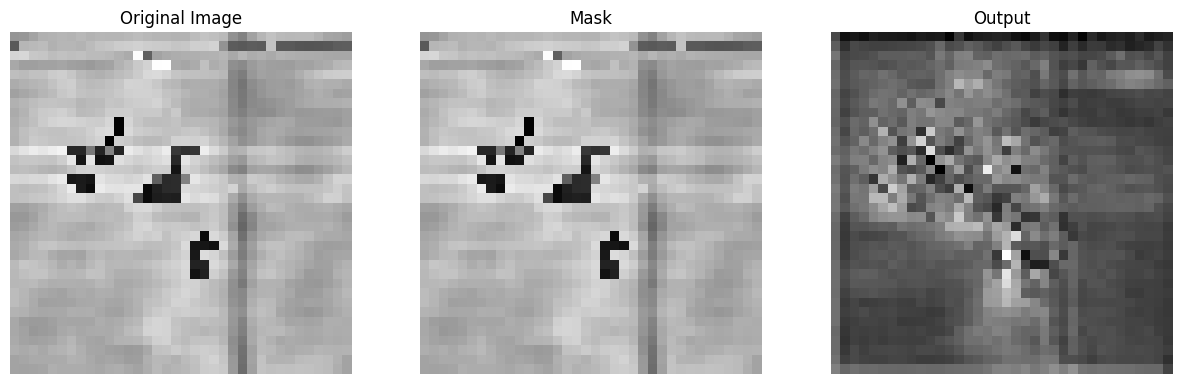

torch.Size([1, 3, 36, 36])
tensor([[[[-0.1588, -0.0793,  0.0946,  ...,  0.0243,  0.1841, -0.0045],
          [ 0.0146,  0.1750,  0.2830,  ...,  0.1054,  0.3947,  0.3291],
          [-0.1105, -0.1938,  0.0274,  ...,  0.2221,  0.5652,  0.5123],
          ...,
          [-0.2766, -0.1090, -0.4673,  ..., -0.5620, -0.5946, -0.3035],
          [-0.1608,  0.0061, -0.2634,  ..., -0.5304, -0.4437, -0.0893],
          [ 0.0915,  0.2167, -0.1563,  ..., -0.2917, -0.0538,  0.1960]],

         [[-0.1588, -0.0793,  0.0946,  ...,  0.0243,  0.1841, -0.0045],
          [ 0.0146,  0.1750,  0.2830,  ...,  0.1054,  0.3947,  0.3291],
          [-0.1105, -0.1938,  0.0274,  ...,  0.2221,  0.5652,  0.5123],
          ...,
          [-0.2766, -0.1090, -0.4673,  ..., -0.5620, -0.5946, -0.3035],
          [-0.1608,  0.0061, -0.2634,  ..., -0.5304, -0.4437, -0.0893],
          [ 0.0915,  0.2167, -0.1563,  ..., -0.2917, -0.0538,  0.1960]],

         [[-0.1588, -0.0793,  0.0946,  ...,  0.0243,  0.1841, -0.0045],
   

KeyboardInterrupt: 

In [57]:
N = 10
idx_images_larger_loss = np.argsort(-np.array(list_loss))[:N]

fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # Create subplots with 1 row and 3 columns

for index, (image, mask, _) in enumerate(train_loader):
    if index in idx_images_larger_loss:
        print(mask.shape)
        print(mask[:10])
        image_np = torch.mean(image, axis=1).cpu().numpy().squeeze(0)  # Convert to numpy array
        mask_np = torch.mean(mask, axis=1).cpu().numpy().squeeze(0)
        output_np = torch.mean(model(image).detach(), axis=1).cpu().numpy().squeeze(0)
        
        axes[0].imshow(image_np, cmap='gray')  # Plot original image
        axes[1].imshow(mask_np, cmap='gray')   # Plot mask
        axes[2].imshow(output_np, cmap='gray') # Plot output
        
        # Set titles for subplots
        axes[0].set_title('Original Image')
        axes[1].set_title('Mask')
        axes[2].set_title('Output')
        
        # Hide axis for better visualization
        for ax in axes:
            ax.axis('off')
        
        plt.show()